In [53]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pylab
import re
import seaborn as sns

from collections import Counter
from nltk import pos_tag, word_tokenize, classify, bigrams, trigrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

%matplotlib inline

In [54]:
edmunds = pd.read_csv("Assignment 3 Edmunds Posts.csv")
senti = pd.read_csv("Assignment 3 Sentiment Scores.csv")

# Part A

### Approach:

For making the unweighted product comparison network, each review was checked against each other reivew in order to determine the direction of the edge. Once the direction was determined, the corresponding edge was added to the product comparison network. The unweighted pagerank is based on the direction of sentiment from one car to another, and does not take into account the relative magnitudes of preferences.

In [55]:
models = list(senti.columns.values)

In [56]:
#create dictionary out of sales for each car brand
CarSales = {'A6': 20000, 'A8':12000, '3series':220000, '5series': 60000, 
            '7series':14000,'XJ': 6600, 'ES':135000, 'LS':30000, 'RX': 120000, 'Sclass':25000}

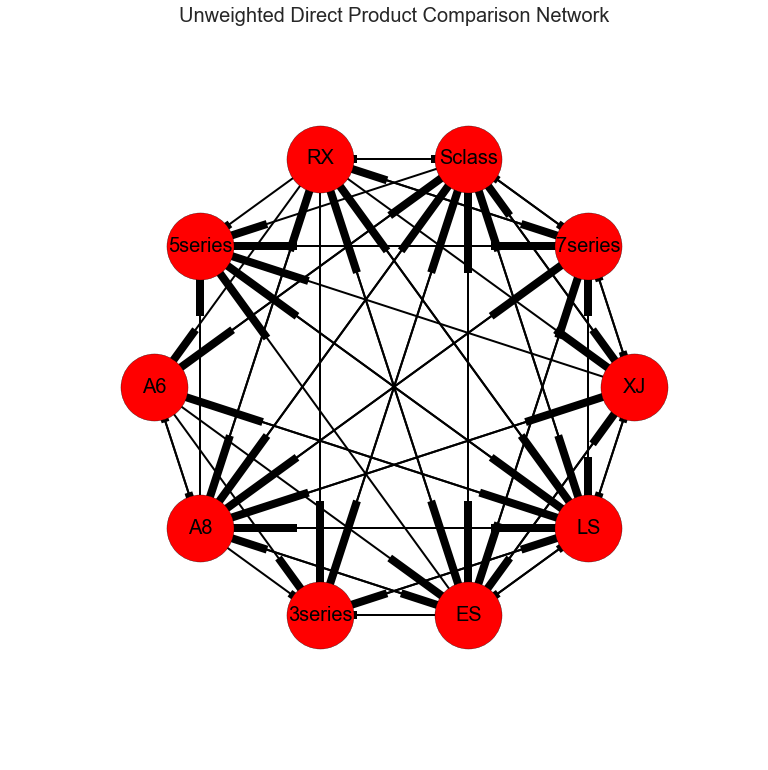

In [57]:
DG = nx.DiGraph()
for i in range(len(senti)):
    for x in senti.columns.values:
        if senti.ix[i][x] > 0:
            for y in senti.columns.values:
                if senti.ix[i][y] > 0:
                    if senti.ix[i][x] > senti.ix[i][y]:
                        if (x,y) not in DG.edges():
                            DG.add_edges_from([(x,y)])

# Create plot
plt.figure(figsize=(10,10))
nx.draw_circular(DG,nodelist=models, font_size=20, width=2, node_size=4500,with_labels=True)

plt.title("Unweighted Direct Product Comparison Network", fontsize=20)

pylab.show()

# Part B - Pagerank Scores

## B1 - Unweighted PageRank

### Approach:

The correlation between the unweighted pagerank and the sales was determined by the listing the pagerank and sales in a dataframe and taking the correlation between the two columns. Additionally the values were plotted to attain a general sense of how the data is distributed.

In [58]:
unweighted_pr = [(key, round(nx.pagerank(DG, alpha=0.9, max_iter=1000)[key],3)) for key in nx.pagerank(DG, alpha=0.9, max_iter=1000)]
sorted(unweighted_pr, key=lambda tup:tup[1], reverse=True)

[('LS', 0.167),
 ('Sclass', 0.128),
 ('7series', 0.123),
 ('5series', 0.096),
 ('A8', 0.096),
 ('ES', 0.095),
 ('XJ', 0.083),
 ('3series', 0.078),
 ('RX', 0.076),
 ('A6', 0.057)]

#### Correlation:

In [59]:
#make dict out of list of tuples from pr scores
carPRscore = dict(unweighted_pr)

sales_corr = pd.DataFrame([carPRscore, CarSales]).T
sales_corr.columns = ['PageRank', 'Sales']
sales_corr.corr()

,PageRank,Sales
PageRank,1.000000,-0.322605
Sales,-0.322605,1.000000


Weighted PageRank v Sales


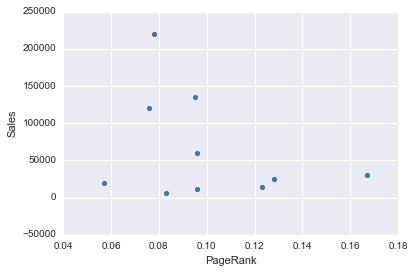

In [60]:
print "Weighted PageRank v Sales"
sales_corr.plot.scatter('PageRank','Sales')

### Conclusion:

There seemes to be a negative correlation of -0.323 between unweighted pagerank and sales. This would be an inaccurate representation of the data, however, as given the distribution shown in the scatter plot, the data does not seem to be linear in nature. Generally speaking, however, it does seem that the average sales of cars with a pagerank less than 0.1 is higher than others. Perhaps this data is not representative of consumer preferences on a whole.

## B2 - Weighted PageRank

### Approach:

Each column of the sentiment data frame was compared to every other column in order to determine the relative magnitude and direction of sentiment. For negative sentiments, the direction of the comparison was flipped and the sentiment turned positive (ie: RX -> LS had a negative sentiment, so LS -> RX has a positive sentiment of the same magnitude). An initial product comparison network model was made using this data, and then the page rank scores were determined from that model. Then a final product comparison network was made, suing the page rank to determine node size.

Similar as before, a data frame was made to determine the correlation between weighted pagerank and sales, and the data points were plotted in order to get a more wholistic view of the data distribution.

In [61]:
col = senti.columns
ar = []
for i in range(len(col)-1):
    for j in range(len(col)):
        if j>i:
            pos = senti[[col[i],col[j]]][(senti[col[i]]>senti[col[j]])]
            neg = senti[[col[i],col[j]]][senti[col[i]]<senti[col[j]]]
            posv = (pos[col[i]]-pos[col[j]]).sum()
            negv = (neg[col[j]]-neg[col[i]]).sum()
            sen = posv-negv
            ar.append((col[i],col[j],sen))

In [62]:
ar2=[]
for i in ar:
    if i[2]<0:
        ar2.append((i[1],i[0],-i[2]))
    else:
        ar2.append(i)

In [63]:
DG=nx.DiGraph()
DG.add_nodes_from(models)
DG.add_weighted_edges_from(ar2)

In [64]:
#get weighted pagerank scores
weighted_pr = nx.pagerank(DG, alpha=0.9)
print "Weighted PageRanks:"
weighted_pr

Weighted PageRanks:


{'3series': 0.09075063199737358,
 '5series': 0.07747619904919195,
 '7series': 0.160637672216164,
 'A6': 0.20423676408794073,
 'A8': 0.18100343990158038,
 'ES': 0.014493643595622937,
 'LS': 0.043016219287835916,
 'RX': 0.013939189488911659,
 'Sclass': 0.15486717266353944,
 'XJ': 0.059579067711839545}

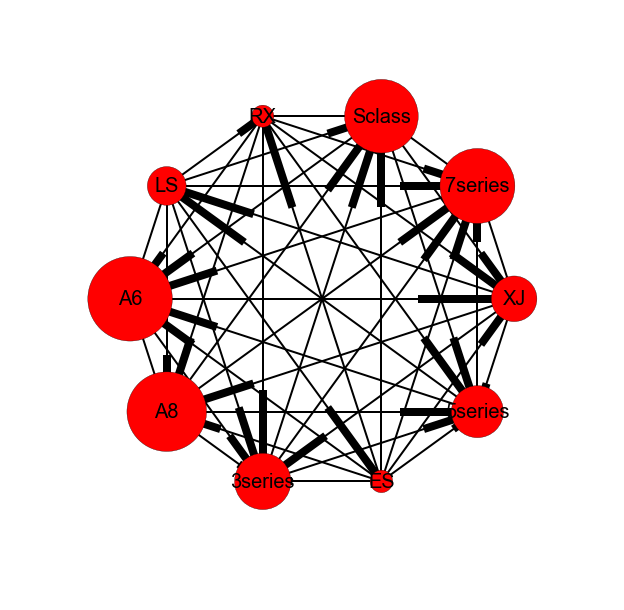

In [65]:
page_rank_arr2 = []
for i in col:
    page_rank_arr2.append(weighted_pr[i]*35000)

plt.figure(figsize=(8,8))
nx.draw_circular(DG,nodelist=models, font_size=20, width=2,
               node_size=page_rank_arr2,with_labels=True)

#### Correlation:

In [66]:
#make dict out of list of tuples from pr scores
carPRscore = dict(weighted_pr)

sales_corr = pd.DataFrame([carPRscore, CarSales]).T
sales_corr.columns = ['PageRank', 'Sales']
sales_corr.corr()

,PageRank,Sales
PageRank,1.000000,-0.488255
Sales,-0.488255,1.000000


Weighted PageRank v Sales


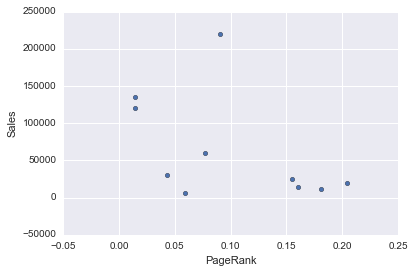

In [67]:
print "Weighted PageRank v Sales"
sales_corr.plot.scatter('PageRank','Sales')

### Conclusion:

Weighted pagerank, unlike unweighted pagerank, takes into account sentiment.

The weighted pagerank shows a negative association with sales. This result comes as a surprise, as one would expect that as the weighted pagerank increases, sales would increase. That being said, by looking at the data it is plain to see that it does not show a linear trend, so this correlation could be seen as an inaccurate assessment of the overall trend. Another possibility might be that the sample taken is biased and does not represent the car market in general.


# Part C - Unsupervised Product Comparsion Network & PageRank

### Approach:

In order to score the relative sentament of the specific cars mentioned in each review, we decided to use the following heuristic: score the sentiment of each *sentence* in which one or more cars are mentioned then take the sum total of sentence-sentiments for each product. While there are obvious limitations to this heuristic, it seemed to perform adequately in a cursory review of the results versus the actual reviews.

To implement the unsupervised sentiment scoring, we took the following steps:

    1. Pulled in words & sentiment weights from SentiStrength
    2. Lemmatized both the sentiment dictionary and tokenized sentences from reviews
    3. Scored the sentement for each of the 10 car models for each sentence
    4. Rolled up the sentence sentiments to the review-level
    5. Coverted sentiments into Pandas Dataframe with structure identical to that provided to us for Parts A & B.
    
Once we had a unsupervised sentiment matrix for each review & product, we built our weighted product comparison network, calculated product PageRank and compared the models PageRank to their Sales, Price & Revenue.

In [68]:
tokenizer = RegexpTokenizer("[\w]+")
lemmatize = WordNetLemmatizer().lemmatize
stop_words= stopwords.words('english')

In [69]:
edmunds_list = list(edmunds['Posts'])

SentiStrength_scores = pd.read_csv("SentiStrength_Dict.csv")
del SentiStrength_scores['Unnamed: 2']
SentiStrength_scores['word'].apply(lemmatize)
senti_dict = SentiStrength_scores.set_index('word')['score'].to_dict()

In [70]:
def SentiRate(tokens_list):
    '''Takes list of tokens and returns a cumulative sentiment score for the
    entire list'''
    sentence_score = 0
    for token in tokens_list:
        if token in senti_dict.keys():
            token_score = senti_dict[token]
            sentence_score += token_score
    return sentence_score

In [71]:
# Initialize dictionary
edmunds_dict = {}
for item in models:
    edmunds_dict[item] = []
for key in edmunds_dict:
    edmunds_dict[key] = [0]*len(edmunds)

In [72]:
i = 0
for review in edmunds_list:
    sentences = []
    for sent in re.split(r'[.]+', review):
        sentences.append(sent)
    for sentence in sentences:
        tokens = [token.lower() for token in tokenizer.tokenize(sentence)]
        tokens = [lemmatize(token) for token in tokens]
        for model in models:
            if model.lower() in tokens:
                sentence_score = SentiRate(tokens)
                edmunds_dict[model][i] += sentence_score
    i += 1

In [73]:
edmunds_scores = pd.DataFrame(edmunds_dict)
edmunds_scores = edmunds_scores.replace({0: np.nan})
edmunds_scores.head()

,3series,5series,7series,A6,A8,ES,LS,RX,Sclass,XJ
0,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,-4.0,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,-2.0,NaN


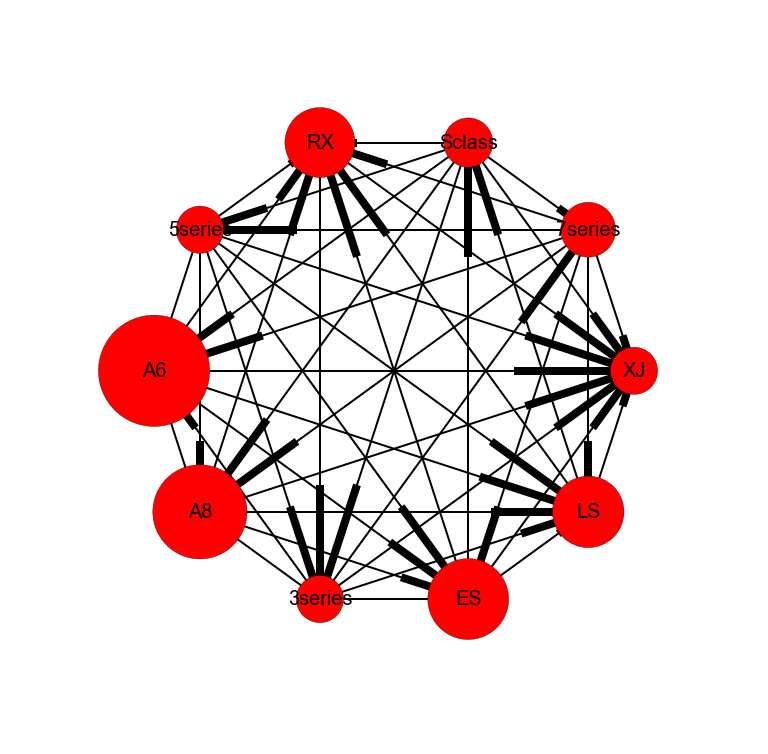

In [74]:
nodes = list(edmunds_scores.columns.values)
col = edmunds_scores.columns

ar = []
for i in range(len(col)-1):
    for j in range(len(col)):
        if j>i:
            pos = edmunds_scores[[col[i],col[j]]][(edmunds_scores[col[i]]>edmunds_scores[col[j]])]
            neg = edmunds_scores[[col[i],col[j]]][edmunds_scores[col[i]]<edmunds_scores[col[j]]]
            posv = (pos[col[i]]-pos[col[j]]).sum()
            negv = (neg[col[j]]-neg[col[i]]).sum()
            sen = posv-negv
            ar.append((col[i],col[j],sen))
            
ar2=[]
for i in ar:
    if i[2]<0:
        ar2.append((i[1],i[0],-i[2]))
    else:
        ar2.append(i)
        
DG=nx.DiGraph()
DG.add_nodes_from(nodes)
DG.add_weighted_edges_from(ar2)

pr = nx.pagerank(DG, alpha=0.9)

page_rank_arr2 = []
for i in col:
    page_rank_arr2.append(pr[i]*50000)
    
plt.figure(figsize=(10,10))
nx.draw_circular(DG,nodelist=models, font_size=20, width=2,
               node_size=page_rank_arr2,with_labels=True)

In [75]:
print "Weighted PageRanks:"
for key, value in sorted(pr.iteritems(), key=lambda (k,v): (v,k)):
    print "%s: %s" % (key, value)

Weighted PageRanks:
ES: 0.0447270799824
LS: 0.0447270799824
Sclass: 0.0447270799824
XJ: 0.0485914470459
RX: 0.0602541874382
7series: 0.0980394959297
5series: 0.10253599917
3series: 0.131004704552
A6: 0.17758172946
A8: 0.247811196457


In [76]:
carPRscore = dict(pr)

sales_corr = pd.DataFrame([carPRscore, CarSales]).T
sales_corr.columns = ['PageRank', 'Sales']

prices = {'3series':33450, '5series':60900, '7series':81500, 'A6':47600, 'A8':82500, 'ES':38900, 'LS':72520, 'RX':43020, 'Sclass':96600, 'XJ':74400}
sales_corr['Price'] = prices.values()
sales_corr['Revenue'] = sales_corr['Price']*sales_corr['Sales']
print 'Correlation Matrix:'
sales_corr.corr()

Correlation Matrix:


,PageRank,Sales,Price,Revenue
PageRank,1.000000,-0.121629,0.394496,-0.058133
Sales,-0.121629,1.000000,0.232618,0.965481
Price,0.394496,0.232618,1.000000,0.424001
Revenue,-0.058133,0.965481,0.424001,1.000000


Unsupervised Sentiment | Sales v PageRank


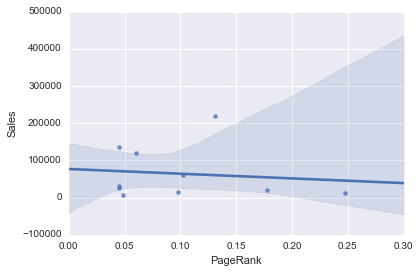

In [77]:
print 'Unsupervised Sentiment | Sales v PageRank'
sns.regplot(data = sales_corr, x = 'PageRank', y = 'Sales')

Unsupervised Sentiment | Price v PageRank


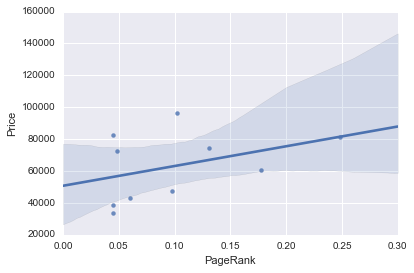

In [78]:
print 'Unsupervised Sentiment | Price v PageRank'
sns.regplot(data = sales_corr, x = 'PageRank', y = 'Price')

### Conclusion:
Like we observed in Part B, there is no real correlation between weighted PageRank derived from the unsupervised product comparison network and sales. However, there is a measurable correlation between PageRank and price. This make some intuitive sense. Higher priced cars are less likely to be mass-produced, which means that the rate at which more positive "buzz" converts to sales might be very different for entry-level vs. high-end cars. Its also not a surprise that more expensive cars - which you'd expect to be of better quality & specifications - would be associated with more positive sentiment from  forum posters (even for posters for which the expensive cars might be unobtainable). Interestingly, if you eliminate "unaffordable" cars and look only at those priced at or under $60,000 there is a very strong correlation between PageRank & Price.

Further analysis with a larger dataset in terms of both reviews and car models would be necessary to establish if the Unsupervised Sentiment Product Comparison Network is a viable means of predicting sales and market share. Additionally, there are many ways to further refine the unsupervised sentiment assessment. For instance, a mapping between the many ways one model could be described (i.e. 7series v. 7 series v. 7-series) and/or a more sophisticated algorithm for proscribing sentiment to specific models (based on word distance & sentence structure) would lead to more accurate sentiment assessments and product comparison networks. But even with the limited data & simplified sentiment assessments, this initial analysis shows promise worthy of further exploration.